# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [3]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../data/train.csv'
test_path  = '../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [4]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [5]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [6]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [7]:
dt.shape, dt_test.shape, concat.shape

((1118822, 53), (9272, 52), (1128094, 53))

In [8]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [9]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 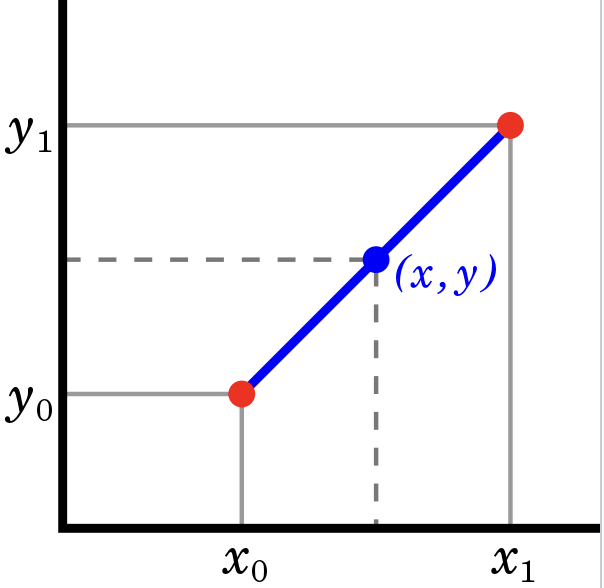

In [10]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [11]:
display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [12]:
display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [13]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [14]:
concat.isnull()

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9268,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9269,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9270,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [15]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

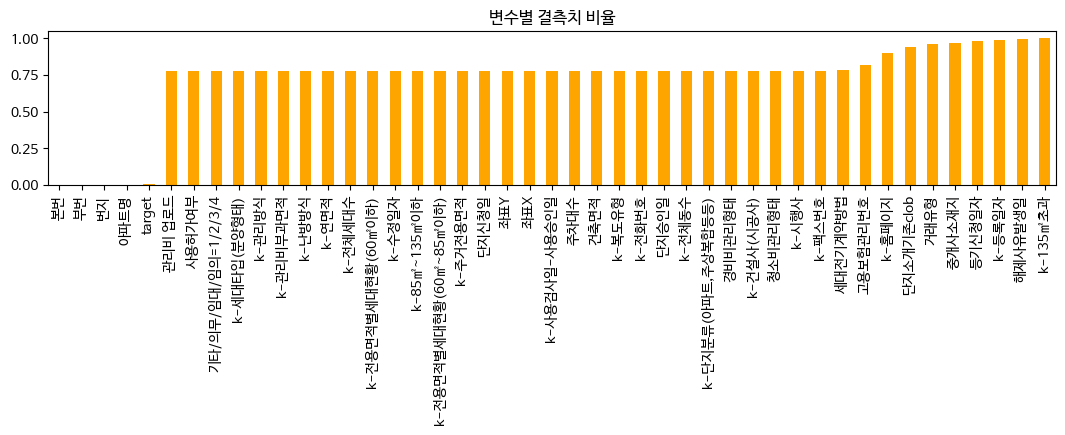

In [16]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [17]:
print(concat.shape[0]*0.9)
concat.columns[concat.isnull().sum() >= 800000]

1015284.6


Index(['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호',
       'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적',
       'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일'],
      dtype='object')

In [18]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 80만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 800000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 80만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 800000]))

* 결측치가 80만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test']
* 결측치가 80만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일']


In [19]:
#[수정코드 1] 결측치 100만개 -> 80만개 이상 컬럼 제거
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 800000])
concat_select = concat[selected]
concat_select.shape

(1128094, 13)

In [20]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구           0
번지          227
본번           75
부번           75
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
dtype: int64

In [21]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 13 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   번지       1127867 non-null  object 
 2   본번       1128019 non-null  float64
 3   부번       1128019 non-null  float64
 4   아파트명     1125958 non-null  object 
 5   전용면적     1128094 non-null  float64
 6   계약년월     1128094 non-null  int64  
 7   계약일      1128094 non-null  int64  
 8   층        1128094 non-null  int64  
 9   건축년도     1128094 non-null  int64  
 10  도로명      1128094 non-null  object 
 11  target   1118822 non-null  float64
 12  is_test  1128094 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 120.5+ MB


In [22]:
concat_select['본번']
concat_select['부번']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
9267    0.0
9268    0.0
9269    0.0
9270    0.0
9271    0.0
Name: 부번, Length: 1128094, dtype: float64

In [23]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [24]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [25]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [26]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구        0
번지         0
본번         0
부번         0
아파트명       0
전용면적       0
계약년월       0
계약일        0
층          0
건축년도       0
도로명        0
target     0
is_test    0
dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

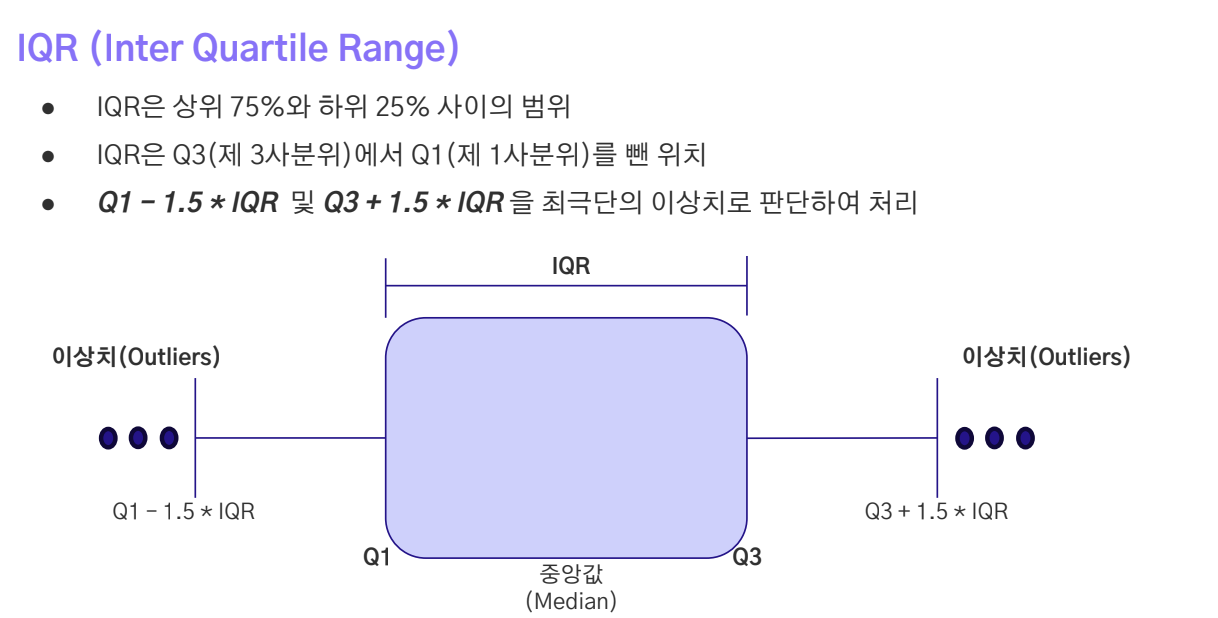

In [27]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 13)


In [28]:
for t in concat_select['target']:
    if t < 0:
        print(t)

In [29]:
print(concat_select.columns)
set(concat_select['target'])

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'target', 'is_test'],
      dtype='object')


{65541.0,
 32775.0,
 98312.0,
 32777.0,
 32780.0,
 32781.0,
 65550.0,
 426000.0,
 32785.0,
 32784.0,
 131091.0,
 163857.0,
 32790.0,
 32791.0,
 65562.0,
 32795.0,
 131100.0,
 32797.0,
 32800.0,
 65570.0,
 32802.0,
 32806.0,
 32809.0,
 98350.0,
 32820.0,
 98360.0,
 32825.0,
 32826.0,
 163900.0,
 32830.0,
 65600.0,
 65605.0,
 65606.0,
 32837.0,
 32840.0,
 32841.0,
 65609.0,
 32843.0,
 32844.0,
 131147.0,
 32847.0,
 32850.0,
 294994.0,
 65620.0,
 295000.0,
 65625.0,
 32860.0,
 32863.0,
 98400.0,
 32864.0,
 32870.0,
 32877.0,
 163950.0,
 98415.0,
 32880.0,
 65649.0,
 65650.0,
 32884.0,
 32889.0,
 32890.0,
 229500.0,
 65660.0,
 98430.0,
 32894.0,
 131200.0,
 32898.0,
 32900.0,
 65670.0,
 98440.0,
 196750.0,
 65681.0,
 98450.0,
 32915.0,
 65684.0,
 32917.0,
 32920.0,
 65690.0,
 65693.0,
 32925.0,
 164000.0,
 32930.0,
 65700.0,
 65703.0,
 590000.0,
 32945.0,
 131250.0,
 32950.0,
 32951.0,
 65720.0,
 32954.0,
 65722.0,
 65724.0,
 98493.0,
 32960.0,
 196800.0,
 65730.0,
 98500.0,
 32965.0,
 329

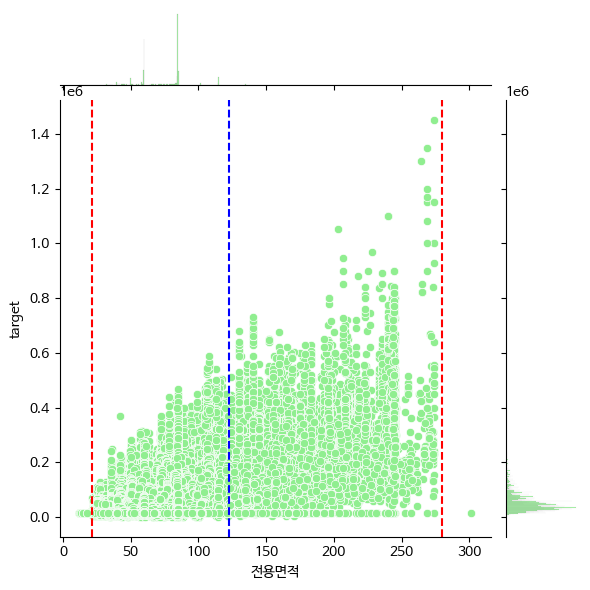

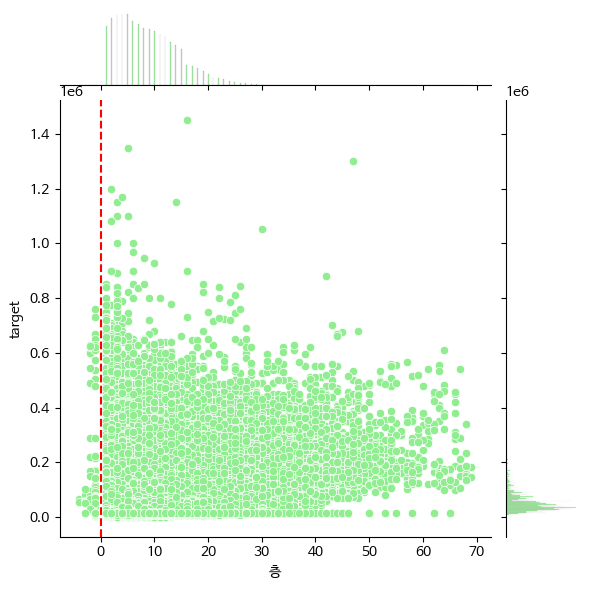

In [52]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
# fig = plt.figure(figsize=(7, 3))
# sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
# plt.title('전용면적 분포')
# plt.xlabel('Area')
# plt.show()

# sns.jointplot(x='전용면적', y='target', data=concat_select, color='lightgreen')
# # plt.axvline(x=280, color='red', linestyle='--')
# plt.axvline(x=21.604999999999997, color='red', linestyle='--')
# plt.axvline(x=122.92500000000001, color='red', linestyle='--')
# plt.show()

#[수정코드 2] 각종 변수에 대해 분포 확인을 위한 작업
sns.jointplot(x='전용면적', y='target', data=concat_select, color='lightgreen')
plt.axvline(x=280, color='red', linestyle='--')
plt.axvline(x=21.604999999999997, color='red', linestyle='--')
plt.axvline(x=122.92500000000001, color='blue', linestyle='--')
plt.show()

sns.jointplot(x='층', y='target', data=concat_select, color='lightgreen')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

In [31]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    #[수정코드 3] upper_bound를 상향하며 버려지던 높은 전용면적의 데이터들을 사용
    lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR
    upper_bound = 280
    
    print(f"{column_name}")
    print(f"[Q1] : {Q1}")
    print(f"[Q3] : {Q3}")
    print(f"[IQR] : {IQR}")
    print(f"[lower_bound] : {lower_bound}")
    print(f"[upper_bound] : {upper_bound}")

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [32]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat_select, '전용면적')

전용면적
[Q1] : 59.65
[Q3] : 84.96
[IQR] : 25.309999999999995
[lower_bound] : 21.68500000000001
[upper_bound] : 280


In [33]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1111690, 13)


In [34]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1102418
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

0    1111428
1        262
Name: 지하여부, dtype: int64

<Axes: xlabel='지하여부', ylabel='target'>

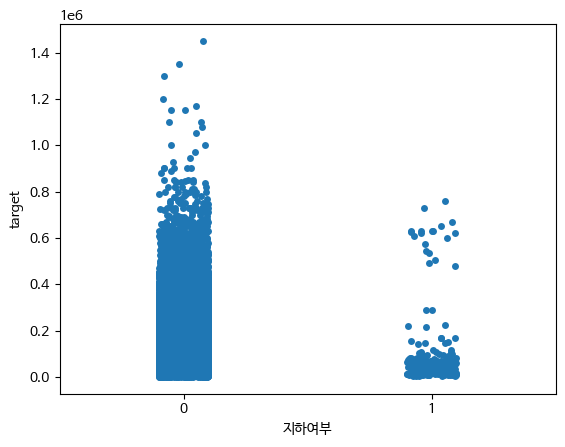

In [37]:
#[수정코드 4] 지하여부 파생변수 추가
concat_select['지하여부'] = concat_select['층'].apply(lambda x: 1 if x < 1 else 0)
display(concat_select['지하여부'].value_counts())

sns.stripplot(y = concat_select['target'], x = concat_select['지하여부'])

In [38]:
concat['시군구'].head()

0    서울특별시 강남구 개포동
1    서울특별시 강남구 개포동
2    서울특별시 강남구 개포동
3    서울특별시 강남구 개포동
4    서울특별시 강남구 개포동
Name: 시군구, dtype: object

In [39]:
concat['계약년월'].head()

0    201712
1    201712
2    201712
3    201801
4    201801
Name: 계약년월, dtype: int64

In [41]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [42]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target',
       'is_test', '지하여부', '구', '동', '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [43]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [44]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [45]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target',
       'is_test', '지하여부', '구', '동', '계약년', '계약월', '강남여부'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [46]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.111690e+06
mean     1.998570e+03
std      9.238404e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [47]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2014 else 0)

In [48]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,is_test,지하여부,구,동,계약년,계약월,강남여부,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,124000.0,0,0,강남구,개포동,2017,12,1,0


In [49]:
concat_select.shape

(1111690, 18)

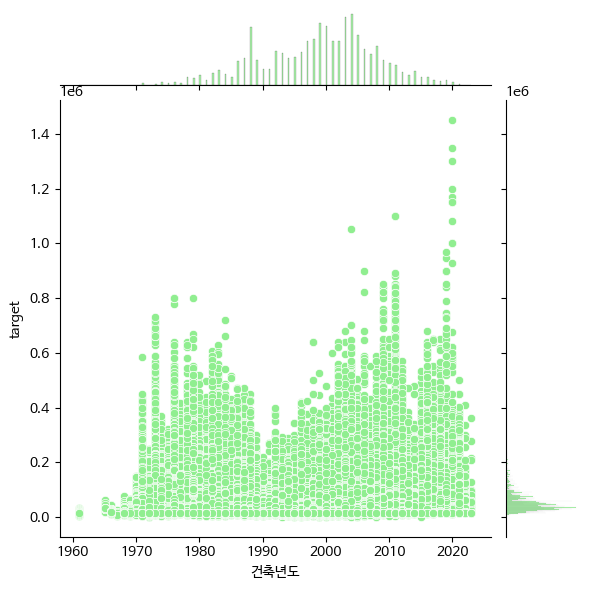

In [51]:
#[수정코드 5] 재개발 아파트 관련 파생변수 테스트 (진행 중)
sns.jointplot(x='건축년도', y='target', data=concat_select, color='lightgreen')
plt.show()

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [53]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1102418, 17) (9272, 17)


In [54]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,지하여부,구,동,계약년,계약월,강남여부,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,언주로 3,13250.0,0,강남구,개포동,2023,07,1,0


In [55]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

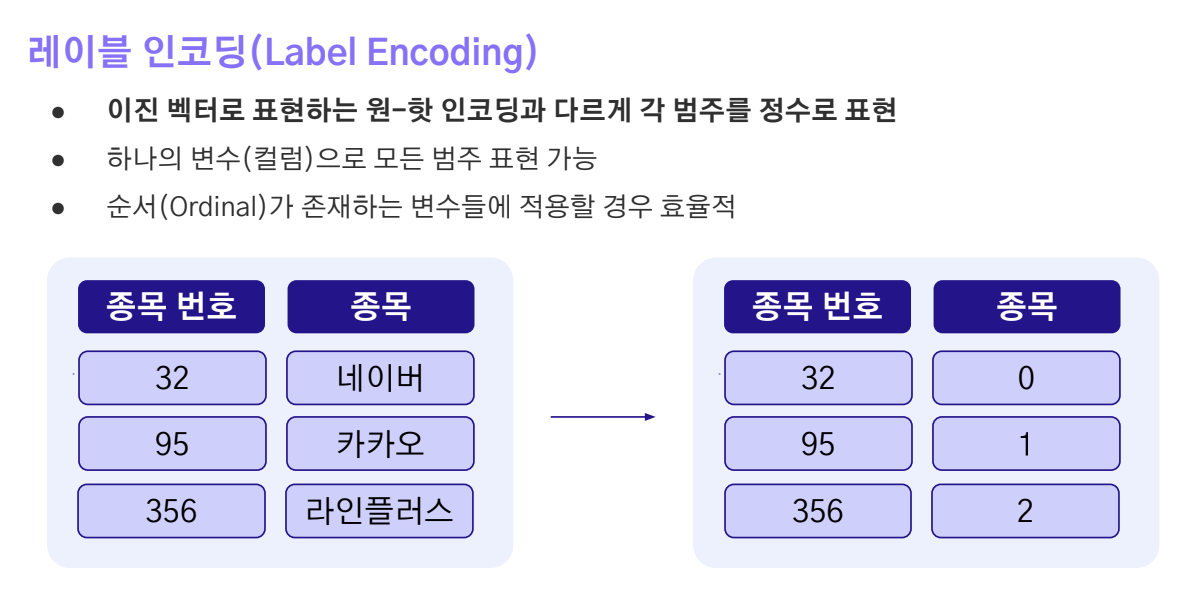

In [56]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'target', '지하여부', '강남여부', '신축여부']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '구', '동', '계약년', '계약월']


In [57]:
for col in categorical_columns_v2:
    
    print(dt_train[col])
    dt_train[col].astype(str)

0          658-1
1          658-1
2          658-1
3          658-1
4          658-1
           ...  
1118817      382
1118818      382
1118819      382
1118820      382
1118821    11-67
Name: 번지, Length: 1102418, dtype: object
0          658.0
1          658.0
2          658.0
3          658.0
4          658.0
           ...  
1118817    382.0
1118818    382.0
1118819    382.0
1118820    382.0
1118821     11.0
Name: 본번, Length: 1102418, dtype: object
0           1.0
1           1.0
2           1.0
3           1.0
4           1.0
           ... 
1118817     0.0
1118818     0.0
1118819     0.0
1118820     0.0
1118821    67.0
Name: 부번, Length: 1102418, dtype: object
0          개포6차우성
1          개포6차우성
2          개포6차우성
3          개포6차우성
4          개포6차우성
            ...  
1118817      갈현현대
1118818      갈현현대
1118819      갈현현대
1118820      갈현현대
1118821        묵정
Name: 아파트명, Length: 1102418, dtype: object
0               언주로 3
1               언주로 3
2               언주로 3
3               언주로 

In [58]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 9/9 [00:02<00:00,  3.40it/s]


In [233]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,지하여부,구,동,계약년,계약월,강남여부,신축여부
0,4630,1141,1,311,79.97,8,3,1987,6052,124000.0,0,0,8,10,11,1,0


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [59]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [60]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [61]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [62]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 7774.192912966348


- 변수 중요도도 확인해보도록 하겠습니다.

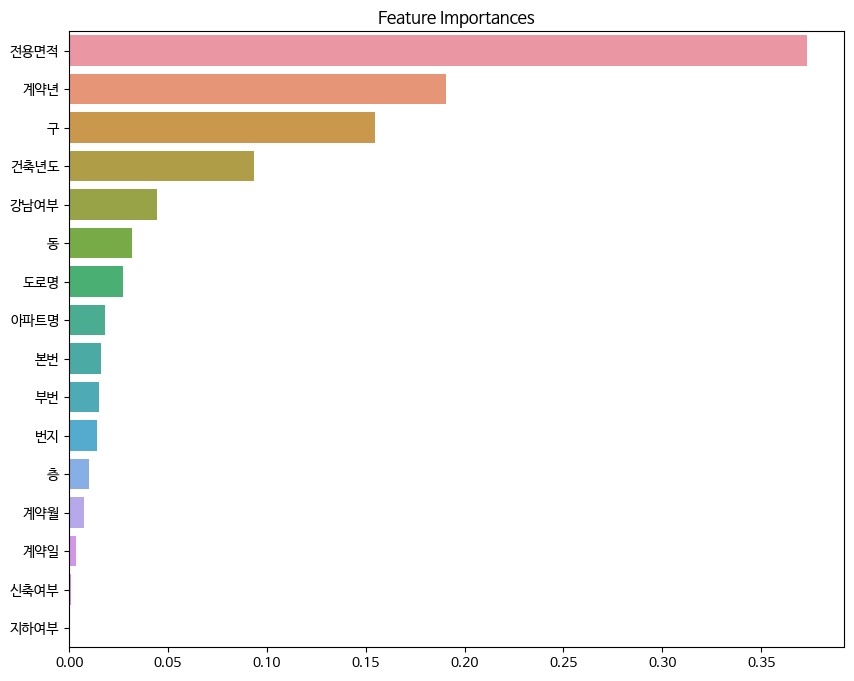

In [63]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [239]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [240]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1308600199.2592 ± 11522267.9461,전용면적
1070691669.9241 ± 15171722.3665,계약년
914582208.7303 ± 10637595.1299,구
474312354.4815 ± 21834479.1553,건축년도
405855234.3975 ± 2477410.1742,강남여부
161249287.5408 ± 7508892.3551,동
134795740.8137 ± 3194802.5451,도로명
78989470.5232 ± 911635.3166,아파트명
78630589.1963 ± 1183749.9919,부번
64067909.8970 ± 2969023.5131,본번


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [241]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [242]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [243]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [244]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,지하여부,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
224567,731,220,0,105,273.96,28,16,2020,5774,0,0,283,15,3,1,1,1450000.0,715754.0,5.391172e+11
224463,4989,1219,266,1930,243.52,28,2,2003,6197,0,0,205,15,0,1,0,72000.0,523400.0,2.037620e+11
288739,3039,819,0,1809,228.34,15,6,2019,8576,0,20,309,14,8,0,1,970000.0,653600.0,1.001090e+11
216023,1086,360,148,5517,273.86,9,4,2002,3281,0,14,150,15,11,1,0,640000.0,330000.0,9.610000e+10
236663,3214,847,0,5538,268.67,30,5,2020,7001,0,20,309,15,3,0,1,1350000.0,1052000.0,8.880400e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [245]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [246]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [247]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,지하여부,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
224567,129,129.0,0.0,PH129,273.96,28,16,2020,압구정로79길 88,0,강남구,청담동,2022,04,1,1,1450000.0,715754.0,5.391172e+11


,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,지하여부,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
930436,1313,1313.0,0.0,수락리버시티4단지,84.81,15,12,2009,누원로 18,0,노원구,상계동,2011,03,0,0,32500.0,32500.0,0.0


- 이제 분포를 비교해보도록 하겠습니다.

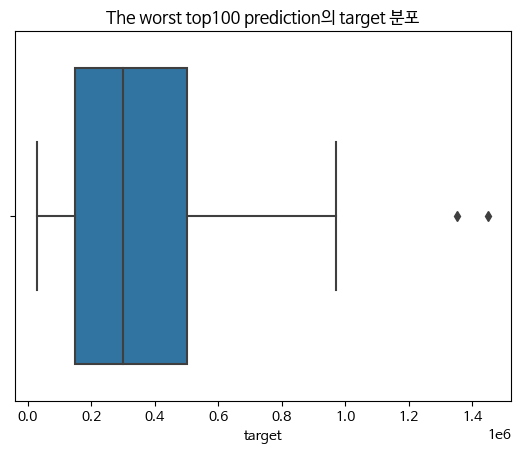

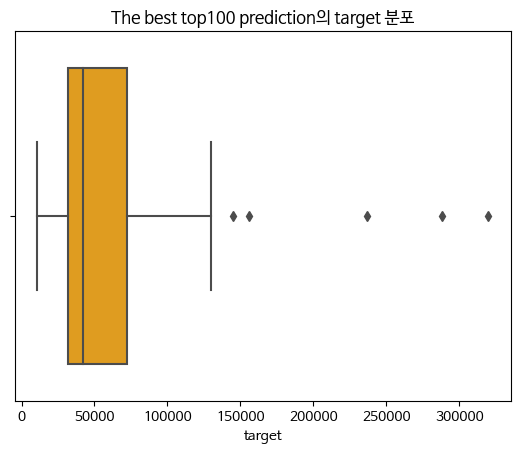

In [248]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

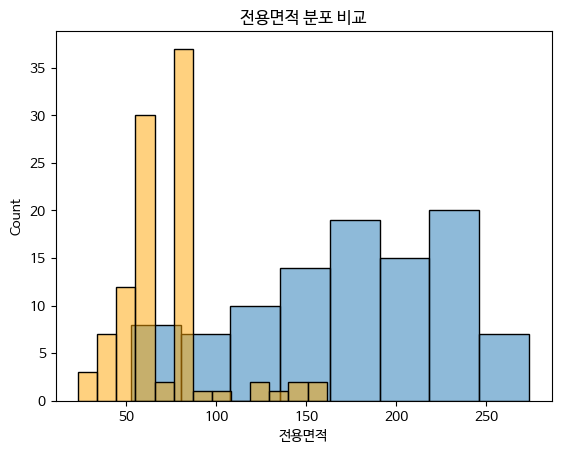

In [249]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [251]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,지하여부,구,동,계약년,계약월,강남여부,신축여부
0,4630,1141,1,311,79.9700,26,5,1987,6052,0,0,0,8,16,6,1,0
1,4605,1134,1,312,108.2017,15,10,2021,459,0,0,0,8,16,7,1,1


In [252]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [253]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 18 ms


In [255]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([194800., 339640., 288600., ...,  82600.,  71600.,  74700.])

## 7. Output File Save

In [256]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)